# Import Libraries

In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt

# Import Datasets

In [3]:
os.chdir('/content/drive/MyDrive/Colab/Datasets/fraud_detection_sets')

# Load datasets
df_transactions = pd.read_csv('transactions_data.csv')
df_users = pd.read_csv('users_data.csv')
df_cards = pd.read_csv('cards_data.csv')
df_fraud_labels = pd.read_json('train_fraud_labels.json').reset_index() # Use read_json to read json file, index the records

# Function to display dataset details
def display_df_info(df, name):
    print(f"\n{name} - Info:")
    print(df.info())

# Display info for each dataframe
display_df_info(df_transactions, "Transactions")
display_df_info(df_users, "Users")
display_df_info(df_cards, "Cards")
display_df_info(df_fraud_labels, "Fraud Labels")


Transactions - Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2661183 entries, 0 to 2661182
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   id              int64  
 1   date            object 
 2   client_id       int64  
 3   card_id         int64  
 4   amount          object 
 5   use_chip        object 
 6   merchant_id     int64  
 7   merchant_city   object 
 8   merchant_state  object 
 9   zip             float64
 10  mcc             int64  
 11  errors          object 
dtypes: float64(1), int64(5), object(6)
memory usage: 243.6+ MB
None

Users - Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2000 non-null   int64  
 1   current_age        2000 non-null   int64  
 2   retirement_age     2000 non-null   int64  
 3   birth_year         2000

# Data Preprocessing

## Check for NAN & Duplicates values

In [4]:
# Check for missing values in all datasets
def check_missing_values(df):
    return df.isnull().sum()

# Print sum of missing values for each set
print(f"\n{check_missing_values(df_transactions)}")
print(f"\n{check_missing_values(df_users)}")
print(f"\n{check_missing_values(df_cards)}")
print(f"\n{check_missing_values(df_fraud_labels)}")

# Drop duplicates for all datasets if any
df_transactions.drop_duplicates(inplace=True)
df_users.drop_duplicates(inplace=True)
df_cards.drop_duplicates(inplace=True)
df_fraud_labels.drop_duplicates(inplace=True)


id                      0
date                    0
client_id               0
card_id                 0
amount                  0
use_chip                0
merchant_id             0
merchant_city           0
merchant_state     312815
zip                330584
mcc                     0
errors            2618999
dtype: int64

id                   0
current_age          0
retirement_age       0
birth_year           0
birth_month          0
gender               0
address              0
latitude             0
longitude            0
per_capita_income    0
yearly_income        0
total_debt           0
credit_score         0
num_credit_cards     0
dtype: int64

id                       0
client_id                0
card_brand               0
card_type                0
card_number              0
expires                  0
cvv                      0
has_chip                 0
num_cards_issued         0
credit_limit             0
acct_open_date           0
year_pin_last_changed    0
card_on_dark_

## Feature Selections

In [5]:
# Drop merchant_state, zip and errors column on transactions df
df_transactions.drop(['merchant_state', 'merchant_city', 'zip', 'errors'], axis=1, inplace=True)

# Drop birth_year, birth_month retirement_age, addresss, lat, long and total_debt columns on users df
df_users.drop(['birth_year', 'birth_month', 'retirement_age', 'address', 'latitude', 'longitude', 'total_debt'], axis=1, inplace=True)

# Drop card_number, expires cvv, id and acct_open_date columns on cards df
df_cards.drop(['card_number', 'expires', 'cvv', 'acct_open_date', 'id'], axis=1, inplace=True)

## Data Cleaning

In [6]:
# Convert amount column from string to numeric on transactions df
df_transactions['amount'] = df_transactions['amount'].str.lstrip('$').astype(float)

# Convert 'date' column to datetime
df_transactions['date'] = pd.to_datetime(df_transactions['date'])

# Convert datetime to timestamp (float)
df_transactions['date'] = df_transactions['date'].astype('int64') / 1e9  # Convert nanoseconds to seconds

# Convert per_capita_income and yearly_income column from string to numeric on users df
df_users['per_capita_income'] = df_users['per_capita_income'].str.lstrip('$').astype(float)
df_users['yearly_income'] = df_users['yearly_income'].str.lstrip('$').astype(float)

# # Convert credit_limit column from string to numeric on cards df
df_cards['credit_limit'] = df_cards['credit_limit'].str.lstrip('$').astype(float)

# Rename columns
df_users.rename(columns={'id': 'client_id'}, inplace=True) # Rename id to client_id
df_fraud_labels.rename(columns={'index': 'transaction_id', 'target': 'is_fraud'}, inplace=True) # Rename index to transaction_id & target to is_fraud
df_transactions.rename(columns={'id': 'transaction_id'}, inplace=True) # Rename id to transaction_id

## Merging Datasets & One-hot Encoding

In [7]:
# Merge Users to transaction
df_transactions = pd.merge(df_transactions, df_users, on="client_id")

# Merge Cards to transaction
df_transactions = pd.merge(df_transactions, df_cards, on='client_id')

# Merge Fraud Labels to transaction
df_transactions = pd.merge(df_transactions, df_fraud_labels, on='transaction_id')

# Run One-hot encoding to categorical columns
df_transactions_encoded = pd.get_dummies(df_transactions, columns=["use_chip", "gender", "card_brand", "card_type", "has_chip", "card_on_dark_web", "is_fraud"], drop_first=True)

# Split data into train and split
X = df_transactions_encoded.drop('is_fraud_Yes', axis=1)
y = df_transactions_encoded['is_fraud_Yes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Shape for training and test
# Check sizes
print(f'Training set: {X_train.shape}')
print(f'Test set: {X_test.shape}')

# Check for class inbalance
np.bincount(y_train)

Training set: (5476287, 24)
Test set: (1369072, 24)


array([5467237,    9050])

# Data Modeling

## Logistic Regression

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


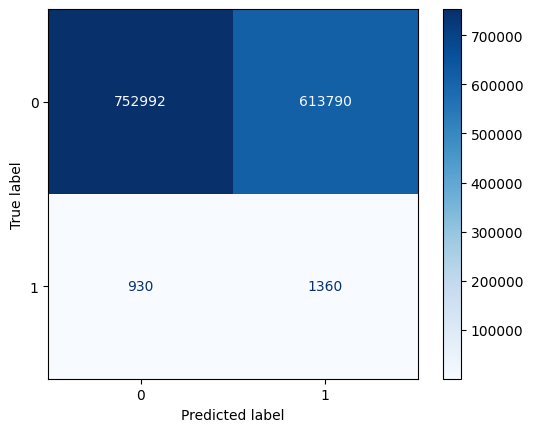

In [32]:
# Train the LogisticRegression Model
model = LogisticRegression(class_weight="balanced") # Due to inbalanced class, use 'class_weight' to add importance to minority class
model.fit(X_train, y_train)

# Predict the model on test set(unseen data)
y_pred_log = model.predict(X_test)

# Visualize Predictions
cm = confusion_matrix(y_test, y_pred_log)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

## Gradient Boosting

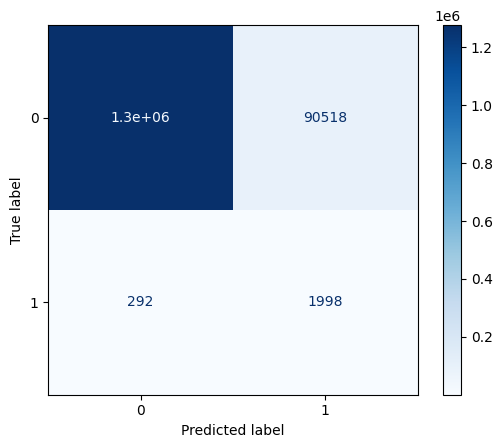

In [31]:
# Compute weights based on class distribution
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

# Train using the Gradient Boosting Classifier
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train, sample_weight=sample_weights)

# Predict the model on test set(unseen data)
y_pred_gb = model.predict(X_test)

# Visualize Predictions
cm = confusion_matrix(y_test, y_pred_gb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

## Neural Network

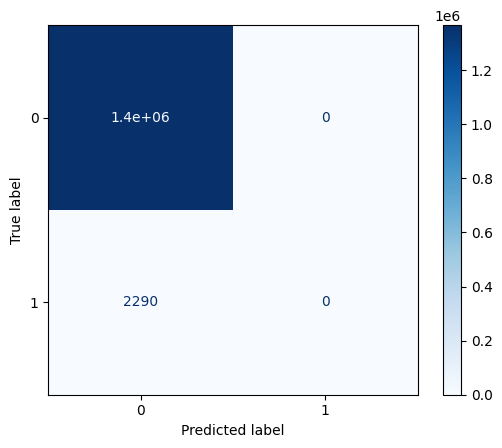

In [8]:
# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train the dataset using MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(50,), max_iter=2000)
model.fit(X_resampled, y_resampled)

# Predict the model on test set(unseen data)
y_pred_nn = model.predict(X_test)

# Visualize Predictions
cm = confusion_matrix(y_test, y_pred_nn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()